In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os
import re


multi_file = True

if multi_file:
    # interesting_files = glob.glob("../data/cuda01/silesia/*.csv")
    interesting_files = glob.glob("../data/gohan/lzbench/profile/*.csv")
    illegal_file = ".*_all.csv"
else:
    input_file = "../data/gohan/lzbench/cuda_all.csv"


name = "tab20"
cmap = mpl.colormaps[name]
colors = cmap.colors

for sus_file in interesting_files:
    if re.match(illegal_file, sus_file):
        interesting_files.remove(sus_file)
 
def fix_chunk_value(chunk_data):
    """ Convert the parameter to bitshifted chunk size """
    return (1 << int(abs(chunk_data)+6))

def fix_compression_ratio(data):
    """ Convert compression percentage to compression ratio """
    return 100/data

def get_chunk_size_from_name(name):
    """ nvcomp_zstd 3.0.5 -10: return 10 """
    return int(re.findall(r'\d+', name)[-1])

def make_groupable_name(name):
    """ Make name constant per compressor """
    return name.split()[0]

def fix_chunk_sizes(df: pd.DataFrame):
    """ Chunk sizes list for plot"""
    if not ('Chunk size' in df.columns):
        df['Chunk size'] = df['Compressor name'].apply(get_chunk_size_from_name)
    df['Chunk size'] = df['Chunk size'].apply(fix_chunk_value)
    return df

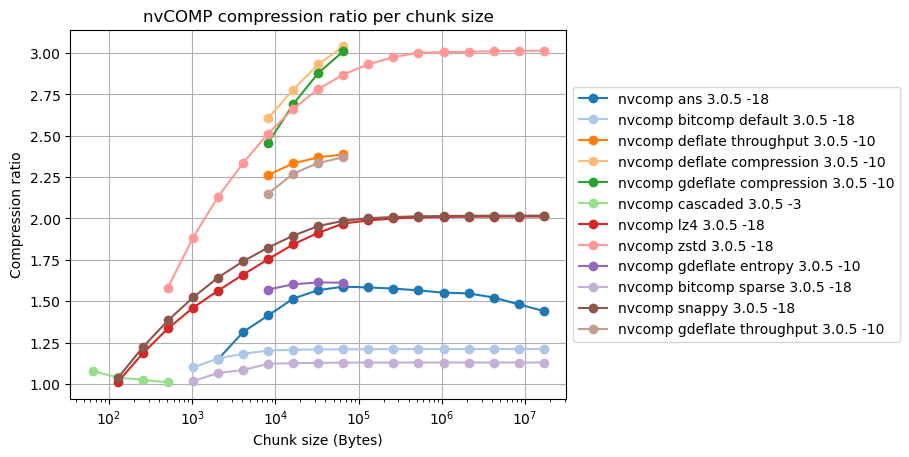

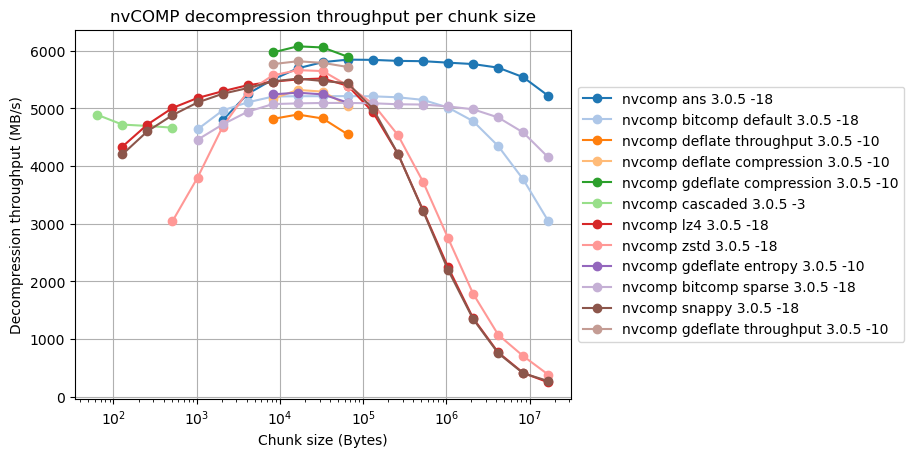

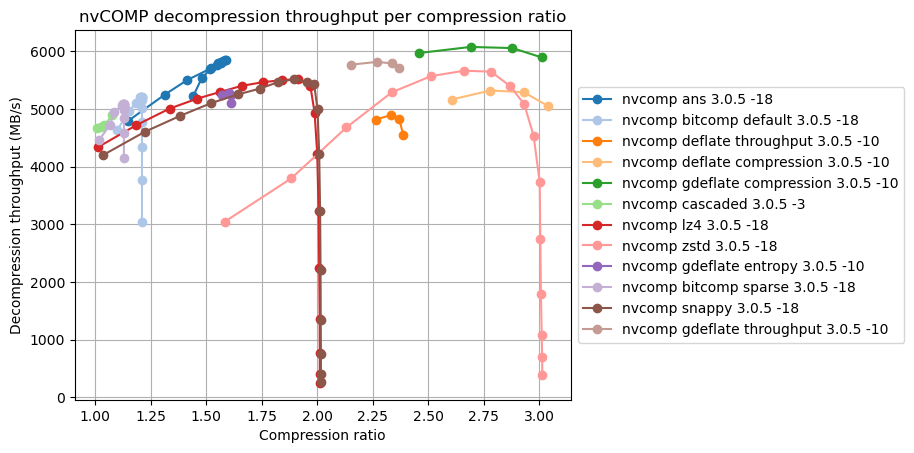

In [53]:
fig_ratio_chunksize, ax_ratio_chunksize = plt.subplots()
fig_decomp_chunksize, ax_decomp_chunksize = plt.subplots()
fig_decomp_ratio, ax_decomp_ratio = plt.subplots()

ax_ratio_chunksize.set_prop_cycle(color=colors)
ax_decomp_chunksize.set_prop_cycle(color=colors)
ax_decomp_ratio.set_prop_cycle(color=colors)

def plot_df(df: pd.DataFrame):
    if len(df) < 2:
        return
    chunk_sizes = df['Chunk size'].to_numpy()
    ratio = fix_compression_ratio(df['Ratio'])
    label = df['Compressor name'].iloc[-1].replace('_', ' ')
    
    ax_ratio_chunksize.plot(chunk_sizes, ratio, marker='o', label=label)
    
    decomp = df['Decompression speed']    
    ax_decomp_chunksize.plot(chunk_sizes, decomp, marker='o', label=label)
    
    ax_decomp_ratio.plot(ratio, decomp, marker='o', label=label)

if multi_file:
    for file in interesting_files:
        df = pd.read_csv(file)
        # Remove memcpy rows
        mask = df['Compressor name'].str.contains('memcpy')
        df = df[~mask]
        df = fix_chunk_sizes(df)
        plot_df(df)
else:
    df = pd.read_csv(input_file)
    # Remove memcpy rows
    mask = df['Compressor name'].str.contains('emcpy')
    df = df[~mask]
    df = fix_chunk_sizes(df)
    df['Compressor name'] = df['Compressor name'].apply(make_groupable_name)
    
    df_groups = df.groupby('Compressor name')
    for name, df_group in df_groups:
        plot_df(df_group)
        

ax_ratio_chunksize.set_xlabel('Chunk size (Bytes)')  
ax_ratio_chunksize.set_ylabel('Compression ratio') 
ax_ratio_chunksize.set_xscale('log')
ax_ratio_chunksize.set_title('nvCOMP compression ratio per chunk size')
ax_ratio_chunksize.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_ratio_chunksize.grid(True)

ax_decomp_chunksize.set_xlabel('Chunk size (Bytes)')  
ax_decomp_chunksize.set_ylabel('Decompression throughput (MB/s)') 
ax_decomp_chunksize.set_xscale('log')
ax_decomp_chunksize.set_title('nvCOMP decompression throughput per chunk size')
ax_decomp_chunksize.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_decomp_chunksize.grid(True)

ax_decomp_ratio.set_xlabel('Compression ratio')  
ax_decomp_ratio.set_ylabel('Decompression throughput (MB/s)') 
ax_decomp_ratio.set_title('nvCOMP decompression throughput per compression ratio')
ax_decomp_ratio.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_decomp_ratio.grid(True)


fig_ratio_chunksize.savefig('nvcomp-ratio-chunksizes.svg')
fig_decomp_chunksize.savefig('nvcomp-decomp-chunksizes.svg')
fig_decomp_ratio.savefig('nvcomp-decomp-ratio.svg')

